In [ ]:
!pip install ta==0.5.25

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")
import pandas_datareader as web
# Technical Analysis library

import ta

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
import pandas_datareader as web

In [ ]:
#df = pd.read_csv("BTC-USD (1).csv")
df = web.DataReader("INR=X" , data_source='yahoo', start="2019-02-01")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-02-01,71.480003,70.919998,70.949997,71.199997,0.0,71.199997
2019-02-04,71.900002,71.400002,71.451698,71.451698,0.0,71.451698
2019-02-05,71.809998,71.510002,71.684998,71.684998,0.0,71.684998
2019-02-06,71.769997,71.449997,71.769997,71.769997,0.0,71.769997
2019-02-07,71.879997,71.269997,71.540497,71.540497,0.0,71.540497
...,...,...,...,...,...,...
2020-11-04,75.000999,74.278801,74.849998,74.655602,0.0,74.655602
2020-11-05,74.407303,73.845802,74.190498,74.379997,0.0,74.379997
2020-11-06,74.278503,73.863998,74.120003,74.120003,0.0,74.120003


In [ ]:
#df['Date'] = pd.to_datetime(df.Date)

# Setting the index
#df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)

## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
df = df.tail(1000)



## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler =  close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [ ]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
  
  
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          
          
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [ ]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [ ]:
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 90, 90)            59040     
_________________________________________________________________
lstm_20 (LSTM)               (None, 90, 30)            14520     
_________________________________________________________________
lstm_21 (LSTM)               (None, 60)                21840     
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1830      
Total params: 97,230
Trainable params: 97,230
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
3/3 [==============================] - 1s 439ms/step - loss: 0.4652 - accuracy: 0.0292 - val_loss: 0.2418 - val_accuracy: 0.0571
Epoch 2/50
3/3 [==============================] - 0s 67ms/step - loss: 0.3907 - accuracy: 0.0260 - val_loss:

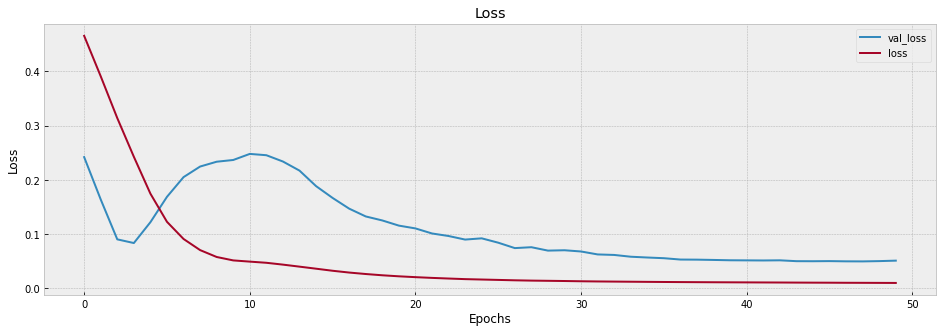

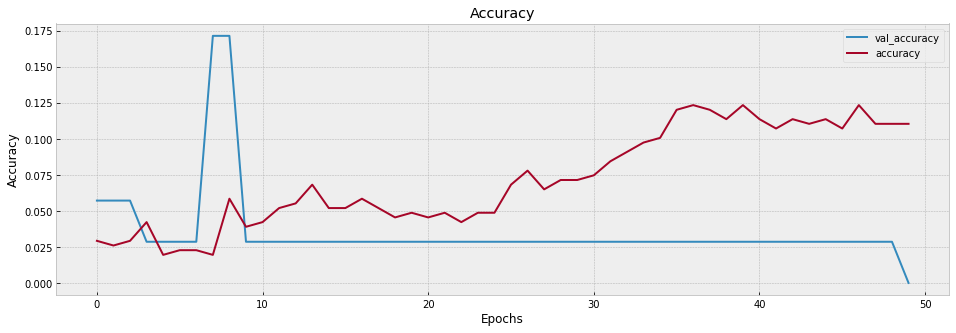

In [ ]:
visualize_training_results(res)

RMSE: 0.37609322376147586


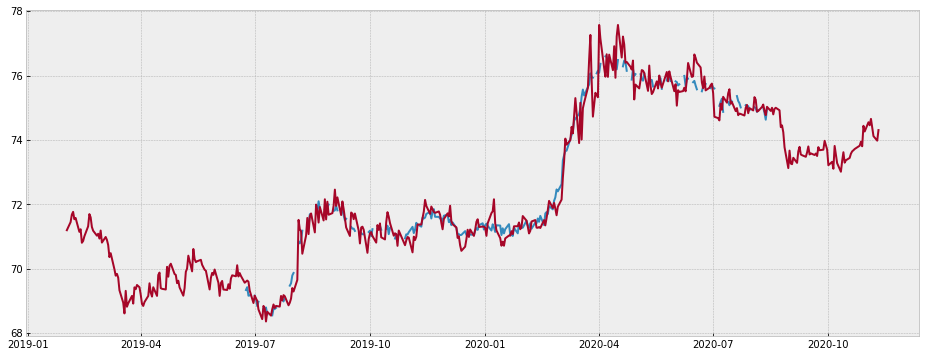

In [ ]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

# plt.title(f"Predicted vs Actual Closing Prices")
# plt.ylabel("Price")
# plt.legend()
# plt.xlim(df.Date.index('01-05-2018'), df.Date.index('01-05-2020'))
# plt.show()

                Close
2020-11-11  75.094238
2020-11-12  74.801689
2020-11-13  75.297920
2020-11-16  74.961258
2020-11-17  74.909996
2020-11-18  74.866158
2020-11-19  74.963577
2020-11-20  74.950943
2020-11-23  74.738625
2020-11-24  74.714081
2020-11-25  74.832222
2020-11-26  74.776573
2020-11-27  74.539650
2020-11-30  74.556305
2020-12-01  75.210014
2020-12-02  74.532532
2020-12-03  74.146156
2020-12-04  74.339363
2020-12-07  74.088905
2020-12-08  74.128952
2020-12-09  74.367165
2020-12-10  74.447571
2020-12-11  74.112099
2020-12-14  74.221786
2020-12-15  74.379562
2020-12-16  73.922211
2020-12-17  73.891785
2020-12-18  73.869820
2020-12-21  73.794548
2020-12-22  74.055435


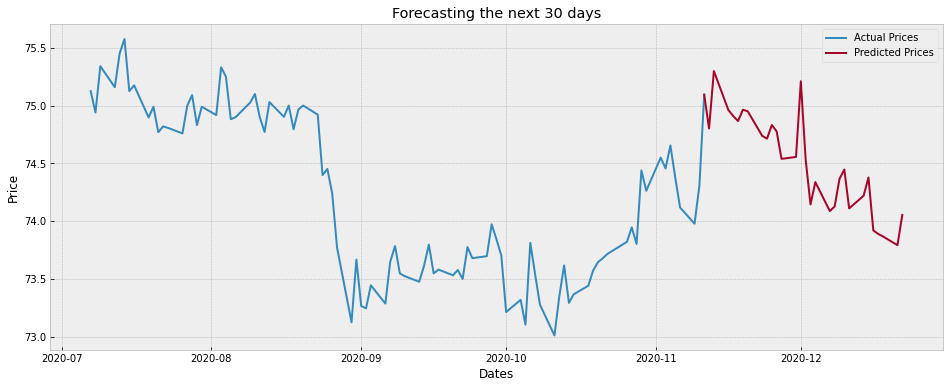

In [ ]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()